In [1]:
import numpy as np
import pandas as pd
from os import listdir
import random
from nltk import ngrams
import spacy
import string
import pickle as pkl
from collections import Counter
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [8]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def build_vocab(all_tokens,max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def token2index_dataset(tokens_data,token2id,id2token):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]




class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim,out_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,out_dim)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out


# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)




batch_size = [64]
lrs = [0.001]
num_grams = [3]
vocab_sizes = [100000]
emb_dims = [100]
optims = ['adam']
max_len_sen = [200]
somelists = [batch_size,optims,lrs,num_grams,vocab_sizes,emb_dims,max_len_sen]

result = list(itertools.product(*somelists))
df_param = pd.DataFrame(result,columns=['batch_size','optimizer','lrs','num_grams','vocab_sizes','emb_dims','max_len_sen'])
df_param['train_loss'] = None
df_param['val_accs'] = None
df_param['best_val_acc'] = None
df_param['epoch_best_acc'] = None


for i in range(len(df_param)):
    print(df_param.iloc[i])
    MAX_SENTENCE_LENGTH = df_param.iloc[i]['max_len_sen']
    train_data_tokens = pkl.load(open("pickle_no_sw/train_data_tokens_grams_{}_no_sw.p".format(df_param.iloc[i]['num_grams']), "rb"))
    all_train_tokens = pkl.load(open("pickle_no_sw/all_train_tokens_grams_{}_no_sw.p".format(df_param.iloc[i]['num_grams']), "rb"))

    val_data_tokens = pkl.load(open("pickles/val_data_tokens_grams_{}.p".format(df_param.iloc[i]['num_grams']), "rb"))
    test_data_tokens = pkl.load(open("pickles/test_data_tokens_grams_{}.p".format(df_param.iloc[i]['num_grams']), "rb"))

    # double checking
    print ("Train dataset size is {}".format(len(train_data_tokens)))
    print ("Val dataset size is {}".format(len(val_data_tokens)))
    print ("Test dataset size is {}".format(len(test_data_tokens)))
    print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))
    
    train_target = pkl.load(open('pickles/train_target.p','rb'))
    val_target = pkl.load(open('pickles/val_target.p','rb'))
    test_target = pkl.load(open('pickles/test_target.p','rb'))
    
    VOCAB_SIZE = df_param.iloc[i]['vocab_sizes']
    token2id, id2token = build_vocab(all_train_tokens,VOCAB_SIZE)

    train_data_indices = token2index_dataset(train_data_tokens,token2id,id2token)
    val_data_indices = token2index_dataset(val_data_tokens,token2id,id2token)
    test_data_indices = token2index_dataset(test_data_tokens,token2id,id2token)

    # double checking
    print ("Train dataset size is {}".format(len(train_data_indices)))
    print ("Val dataset size is {}".format(len(val_data_indices)))
    print ("Test dataset size is {}".format(len(test_data_indices)))


    BATCH_SIZE = int(df_param.iloc[i]['batch_size'])
    print(BATCH_SIZE)
    train_dataset = NewsGroupDataset(train_data_indices, train_target)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_target)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_target)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    emb_dim = df_param.iloc[i]['emb_dims']
    out_dim = 2
    model = BagOfWords(len(id2token), emb_dim,out_dim).to(DEVICE)


    learning_rate = df_param.iloc[i]['lrs']
    num_epochs = 3 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    if(df_param.iloc[i]['optimizer'] == 'adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)



    train_loss_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        for j, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            train_loss_history.append(loss.item())
            # validate every 100 iterations
            if j > 0 and j % 25 == 0:
                # validate
                
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}'.format( 
                           epoch+1, num_epochs, j+1, len(train_loader), loss.item()))

        val_acc = test_model(val_loader, model)
        val_acc_history.append(val_acc)
        print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, j+1, len(train_loader), val_acc))



    val_acc_history = np.array(val_acc_history)
    max_val_acc = np.max(val_acc_history)
    max_val_acc_epoch = np.argmax(val_acc_history)
    
    df_param.at[i,'train_loss'] = train_loss_history
    df_param.at[i,'val_accs'] = val_acc_history
    df_param.at[i,'best_val_acc'] = max_val_acc
    df_param.at[i,'epoch_best_acc'] = max_val_acc_epoch+1
    
pkl.dump(df_param,open('result_df_max_sen.pkl','wb'))

batch_size            64
optimizer           adam
lrs                0.001
num_grams              3
vocab_sizes       100000
emb_dims             100
max_len_sen          200
train_loss          None
val_accs            None
best_val_acc        None
epoch_best_acc      None
Name: 0, dtype: object
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 7542090
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
64
Epoch: [1/3], Step: [26/313], Train Loss: 0.6956608295440674
Epoch: [1/3], Step: [51/313], Train Loss: 0.6922227740287781
Epoch: [1/3], Step: [76/313], Train Loss: 0.6804366707801819
Epoch: [1/3], Step: [101/313], Train Loss: 0.6813633441925049
Epoch: [1/3], Step: [126/313], Train Loss: 0.6684738397598267
Epoch: [1/3], Step: [151/313], Train Loss: 0.66904616355896
Epoch: [1/3], Step: [176/313], Train Loss: 0.6717649698257446
Epoch: [1/3], Step: [201/313], Train Loss: 0.66898554563522

In [51]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        which_correct = predicted.eq(labels.view_as(predicted)).numpy()
        #print(which_correct)
        which_correct_idx = np.where(which_correct == 1)[0]
        #print('which correct,{}'.format(which_correct_idx))
        which_incorrect_idx = np.where(which_correct == 0)[0]
        #print('which incorrect,{}'.format(which_incorrect_idx))
        #total += labels.size(0)
        #correct += predicted.eq(labels.view_as(predicted)).sum().item()
        print(data.numpy()[which_correct_idx[4:7],:],data.numpy()[which_incorrect_idx[:3],:])
        return data.numpy()[which_correct_idx[4:7],:],data.numpy()[which_incorrect_idx[4:7],:]
        #return data.numpy()[which_correct_idx[:3]], data.numpy()[which_incorrect_idx[:3]]


In [44]:
def index2token_dataset(tokens_data,token2id,id2token):
    indices_data = []
    for tokens in tokens_data:
        index_list = [id2token[token] for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [57]:
correct_data = index2token_dataset(correct_examples,token2id,id2token)

In [58]:
data_inc = [' '.join(ex) for ex in correct_data]
data_inc

["i saw one of the stage performances in denver and have never been less impressed the word vagina says it all a body part nothing shocking here i could say to my doctor my left arm has been hurting a bit after tennis or my vagina hurts after cycling with equal or more social commentary it could be the <unk> monologues for all the entertainment or radical comment i heard the monologues were dull but delivered with drama the topics were outdated and i was alternately bored and annoyed once i think i laughed but apparently it was n't when i was supposed to surely this is n't really a hit oh and spoilers there was a lesbian oh wait maybe not come to think of it and inappropriate fondling and a crack mama that about covers it i saw <unk> one of of the the stage <unk> performances in <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> the word <unk> <unk> says it it all <unk> <unk> <unk> <unk> <unk> <unk> here i i could <unk> <unk> <unk> <unk> <unk> my left <unk> <unk> has been <unk> <unk> a bi

In [59]:
incorrect_data = index2token_dataset(incorrect_examples,token2id,id2token)

In [60]:
data_inc = [' '.join(ex) for ex in correct_data]
data_inc

["i saw one of the stage performances in denver and have never been less impressed the word vagina says it all a body part nothing shocking here i could say to my doctor my left arm has been hurting a bit after tennis or my vagina hurts after cycling with equal or more social commentary it could be the <unk> monologues for all the entertainment or radical comment i heard the monologues were dull but delivered with drama the topics were outdated and i was alternately bored and annoyed once i think i laughed but apparently it was n't when i was supposed to surely this is n't really a hit oh and spoilers there was a lesbian oh wait maybe not come to think of it and inappropriate fondling and a crack mama that about covers it i saw <unk> one of of the the stage <unk> performances in <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> the word <unk> <unk> says it it all <unk> <unk> <unk> <unk> <unk> <unk> here i i could <unk> <unk> <unk> <unk> <unk> my left <unk> <unk> has been <unk> <unk> a bi

In [52]:
correct_examples,incorrect_examples=test_model(val_loader,model)

[[    2    95   200   288     7   756   236    50 13637    37  2285  1803
  21445  9062  1574     7   561 32762   438    10   223    43   549  2205
   1190  1634   884     2  3378 12897   302   224   905   224   181  3627
   5028 21445 15117    43   103   314 32251   914   224 32762  5944   314
  60000   451  3872   914  2225   934  1781    10  3378  2802     7     1
  13566   213   223     7   621   914  8859   855     2   428     7 13566
   5863   649    30  2339   451   328     7  7509  5863  7983    37     2
   1478 15967  1040    37  3905  1604     2    25     2  1530    30   557
     10  1478     8   170     2  1478   294   302  1259    12   461     8
   1471    43   436   343    37  1364    47  1478    43  2774   343   788
    163   141    98   302    25   288    10    37  5858 70008    37    43
   5397  8490   118  2690  3850    10   188     1 77622  2168 86508     1
  88399     1     1     1     1     1     1     1     1 18027     1     1
  55238 62274     1     1     1     1 

In [2]:
df_param = pkl.load(open('result_df_max_sen.pkl','rb'))

In [3]:
df_param

,batch_size,optimizer,lrs,num_grams,vocab_sizes,emb_dims,max_len_sen,train_loss,val_accs,best_val_acc,epoch_best_acc
0,64,adam,0.001,1,50000,256,200,"[0.7148686051368713, 0.6974472403526306, 0.701...","[79.94, 82.44, 81.74, 80.52, 80.74, 80.58, 81....",82.44,2
1,64,adam,0.001,1,50000,256,500,"[0.6926628947257996, 0.6891888380050659, 0.686...","[79.74, 76.2, 75.86, 78.64, 77.72, 80.04, 80.0...",80.04,6
2,64,adam,0.001,2,50000,256,200,"[0.6967634558677673, 0.7066025137901306, 0.706...","[79.18, 83.24, 82.34, 80.48, 80.48, 80.04, 79....",83.24,2
3,64,adam,0.001,2,50000,256,500,"[0.6879203915596008, 0.6846935153007507, 0.689...","[72.3, 80.56, 80.14, 79.34, 82.42, 83.0, 82.12...",83,6


In [8]:
print(df_param.to_latex(index=False))

\begin{tabular}{rlrrrrrllll}
\toprule
 batch\_size & optimizer &    lrs &  num\_grams &  vocab\_sizes &  emb\_dims &  max\_len\_sen &                                         train\_loss &                                           val\_accs & best\_val\_acc & epoch\_best\_acc \\
\midrule
         64 &      adam &  0.001 &          1 &        50000 &       256 &          200 &  [0.7148686051368713, 0.6974472403526306, 0.701... &  [79.94, 82.44, 81.74, 80.52, 80.74, 80.58, 81.... &        82.44 &              2 \\
         64 &      adam &  0.001 &          1 &        50000 &       256 &          500 &  [0.6926628947257996, 0.6891888380050659, 0.686... &  [79.74, 76.2, 75.86, 78.64, 77.72, 80.04, 80.0... &        80.04 &              6 \\
         64 &      adam &  0.001 &          2 &        50000 &       256 &          200 &  [0.6967634558677673, 0.7066025137901306, 0.706... &  [79.18, 83.24, 82.34, 80.48, 80.48, 80.04, 79.... &        83.24 &              2 \\
         64 &      adam &

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

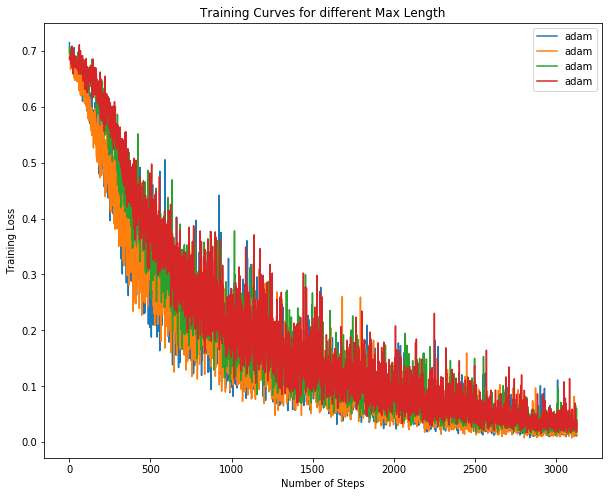

In [6]:
plt.figure(figsize=(10,8))

for i in range(len(df_param)):
    plt.plot(range(len(df_param.iloc[i]['train_loss'])),df_param.iloc[i]['train_loss'],label=str(df_param.iloc[i]['optimizer']))
    

plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different Max Length')
plt.savefig('plots/training_curve_max_len.png')

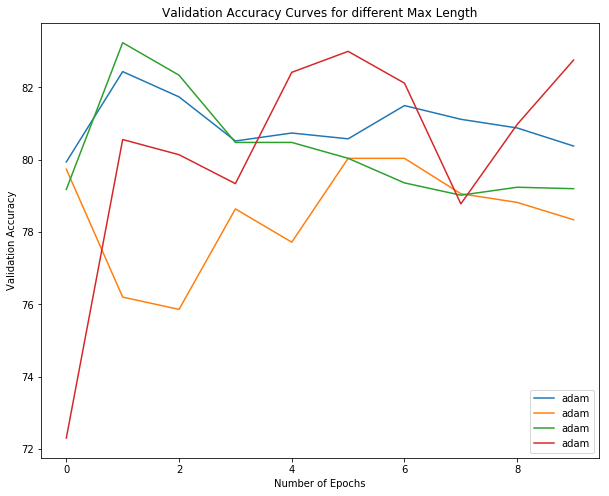

In [7]:
plt.figure(figsize=(10,8))

for i in range(len(df_param)):
    plt.plot(range(len(df_param.iloc[i]['val_accs'])),df_param.iloc[i]['val_accs'],label=str(df_param.iloc[i]['optimizer']))
    

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for different Max Length')
plt.savefig('plots/accuracy_max_len.png')